## Titanic コンペをやろう

- 下記のNotebookをほぼそのまま利用しています。  
https://www.kaggle.com/startupsci/titanic-data-science-solutions

- **[重要] この回はコードを理解するというよりデータ分析の流れを理解することに努めてほしいと考えています**

### ■ 事前準備
- kaggleのアカウントを作成する (持ってない人対象)
    - https://www.kaggle.com/account/login?phase=startRegisterTab&returnUrl=%2Fc%2Ftitanic
- Titanicのコンペに参加する (参加していない人対象)
    - https://www.kaggle.com/c/titanic
- Dataタブから3つのcsvデータをダウンロードする（Download Outputを選べば、自動的に圧縮されたtitanic.zipがダウンロードされる）

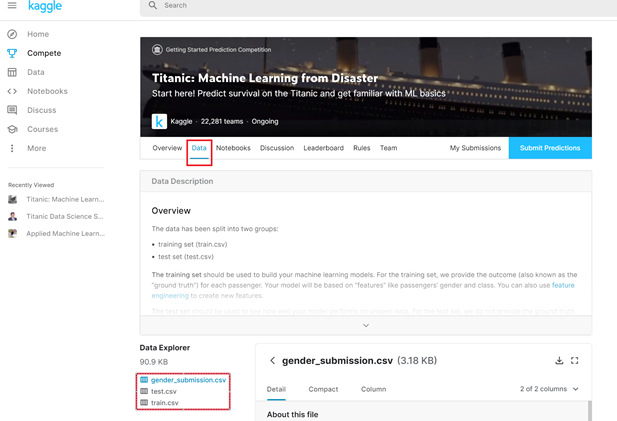

- ダウンロードしたファイルが解凍された形で同階層に存在する状態にする

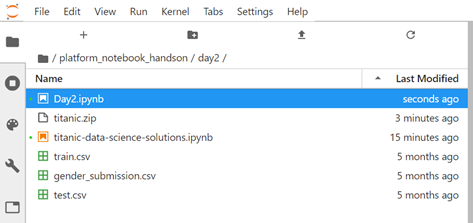

### ■ お題の確認をしよう

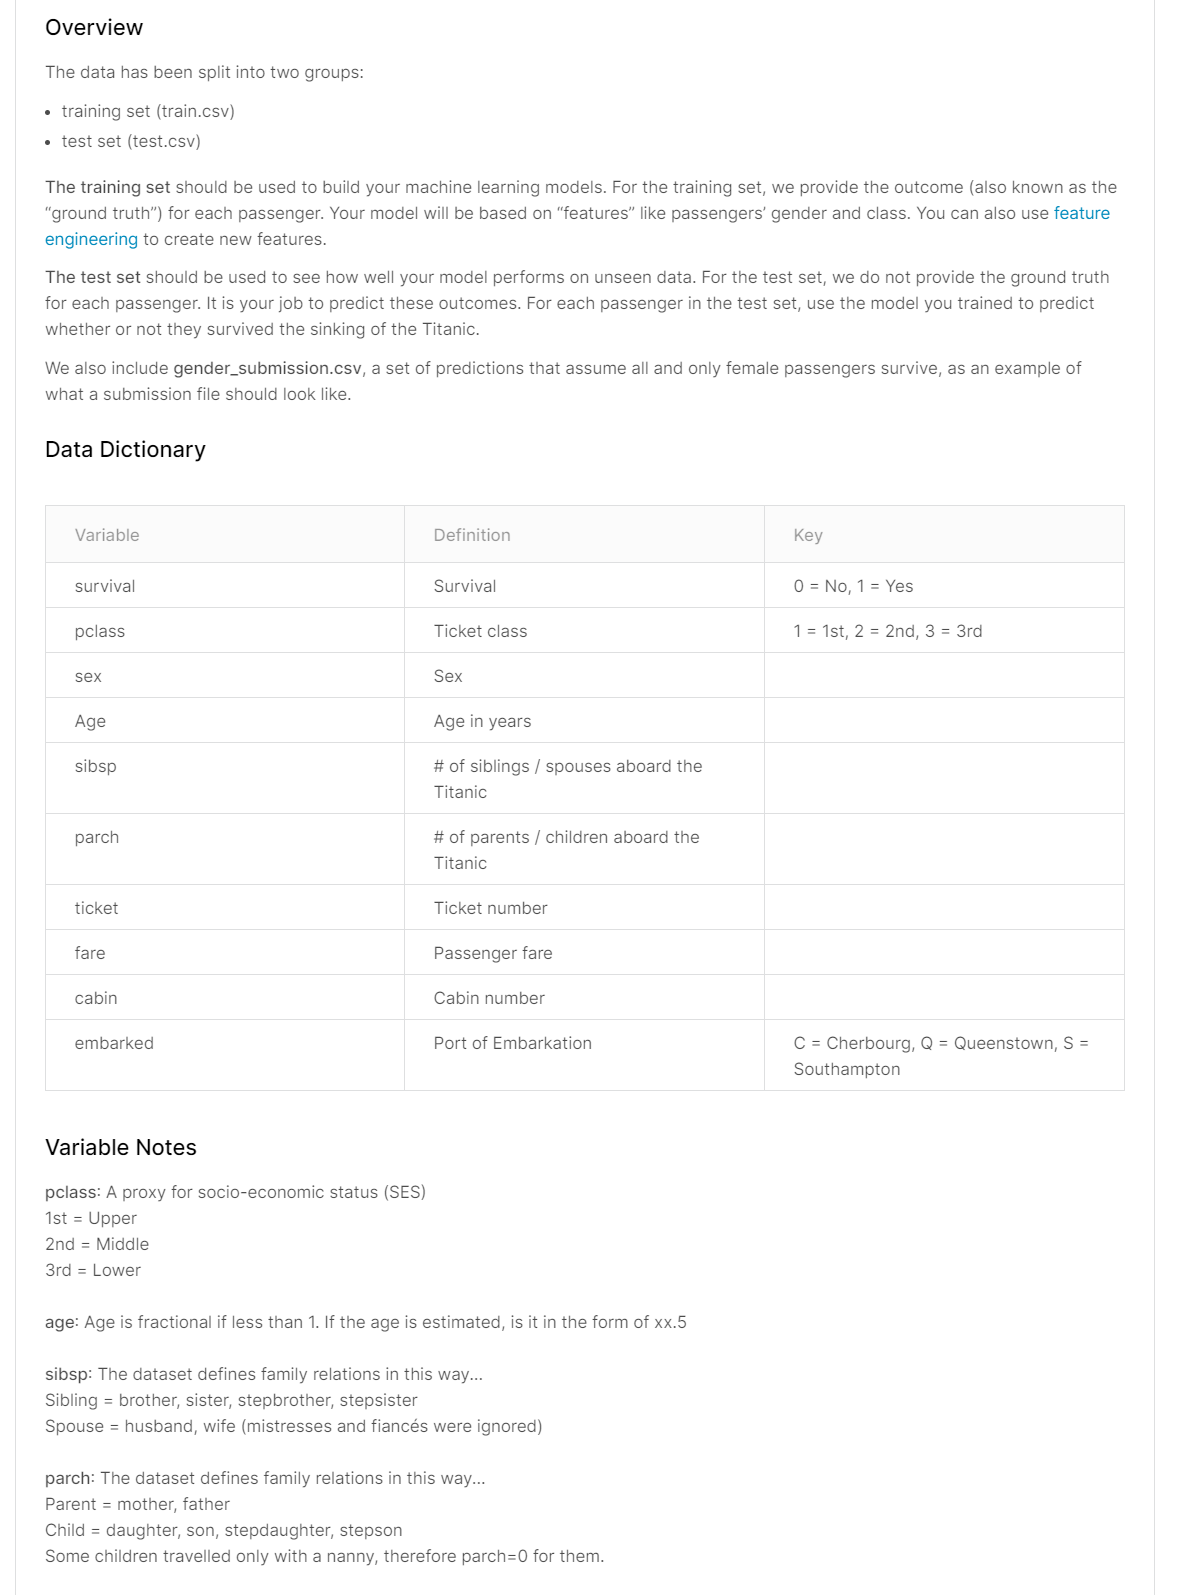

#### なるほど（わからん）人のための翻訳
##### ■ アウトライン
- トレーニングセットは、機械学習モデルを構築するために使用する必要があります。
- トレーニングセットでは、各乗客の結果を提供します。あなたのモデルは、乗客の性別やクラスなどの「特徴」に基づいています。また、特徴工学を使って新しい特徴を作成することもできます。
- テストセットは、目に見えないデータでモデルがどの程度の性能を発揮するかを確認するために使用します。
- テストセットでは、各乗客の基本的な真実を提供しません。**これらの結果を予測するのはあなたの仕事です。テストセットの各乗客について、あなたが訓練したモデルを使用して、彼らがタイタニック号の沈没で生き残ったかどうかを予測してください。**
- また、投稿ファイルがどのように見えるかの例として、すべての女性乗客が生き残ったと仮定した予測のセット、gender_submission.csvも含まれています。

##### ■ データにおける補足
- pclassってなんですか？
```
pclass。社会経済的地位の表現
1位＝上
2位＝中
3位＝下
```
- ageってどんな年齢が設定されていますか
```
年齢は 1 より小さい場合は端数である。年齢が推定されている場合は xx.5 の形式である．
```
- Siblingってなんですか？
```
家族の関係性を定義している指標となる
Sibling は 兄弟、姉妹、義理の兄弟、義理の姉
spouse は 夫、妻（愛人や婚約者は無視された
```
- parchってなんですか？
```
家族の関係性を定義している指標となる
Parents は 父,母
child は 娘, 息子, 連れ子
乳母のみと旅をしている場合はparch=0となります。
```

### ■ コードの下準備

In [1]:
# seabornのインストール (グラフの可視化をより綺麗に見せることができる)

!pip install seaborn

     |████████████████████████████████| 225kB 10.0MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
# データをDataFrameとしてloadする（前回からのおさらい）
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
# combineはlist形式で格納されているだけ
combine = [train_df, test_df]

In [29]:
# カテゴリデータと数値データ
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


### データの情報を深く掘っていく
- 仮説をもって、学習に使用するデータ（カラム）を決定していく作業

In [30]:
# データを見てみる
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [32]:
# データのカラム単位でどのような揺らぎがある項目なのかをチェックしてみる

In [33]:
#もう少しデータの詳細を追ってみる
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

#### 上記のデータからわかること
- 欠損している情報があること (上から順に欠損率が大きい)
 - Cabibn (train & test)
 - Age (train & test)
 - Embarked
 - Fare

In [34]:
# さらにデータを深掘る
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### ここから分かること
- 総サンプル数は、タイタニック号に乗っていた実際の乗客数（2,224人）の40％にあたる891人です。
- 生存率は、0または1の値を持つcategoricalな特徴である。
- 約38％のサンプルが生存しており、実際の生存率32％を代表しています。
- ほとんどの乗客（75％以上）は親子連れではありませんでした。
- 乗客の30％近くが兄弟や配偶者を連れていました。
- 運賃には大きなばらつきがあり、512ドルという高額な料金を支払っている乗客はほとんどいませんでした（1％未満）。
- 65歳から80歳までの高齢者の乗客はほとんどいませんでした（1％未満）。

In [35]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Longley, Miss. Gretchen Fiske",male,1601,G6,S
freq,1,577,7,4,644


#### ここから分かること
- nameはデータセット全体を通して一意である (count=unique=891)
- 65%が男性（top=男性、freq=577/count=891）
- キャビンの値は、サンプル間で複数の重複がある。あるいは、複数の乗客がキャビンを共有している場合もあります。
- Embarkedの値は3つの可能性があります。ほとんどの乗客はS港から乗船 (トップ=S)
- チケット機能は、重複値の比率が高い(22%) (unique=681)。

#### ここまでで生存と各カラムの相関に仮説を設定してみる

- 生存率とageは確実に相関しているので、データ補間してもいいかも
- Embarkedは、生存または別の重要な特徴と相関があるかもしれないので、こちらも同様
- Ticketsは、重複率が高く(22%)、チケットと生存率の間に相関がない可能性があるので、分析から除外する可能性あり
- Cabinは、訓練データとテストデータの両方において非常に不完全であったり、NULLを多く含んでいたりするため、削除の可能性あり
- PassengerIdは生存率に寄与しないので、削除する可能性あり
- Nameは比較的標準的ではなく、生存率に直接寄与しないため、削除される可能性あり
- ParchとSibSpに基づいてFamilyという新しい機能を作成して、搭乗している家族の総数を取得するのは良いかもしれない
- 名前機能を改良して、新しい機能としてタイトルを抽出できるようにする可能性はある
- 年齢帯のための新しい機能をつくる。これにより、連続した数値特徴量を順序的なカテゴリ特徴量に変えることが可能となる。また、運賃範囲特徴を作成する可能性もある。

### ■ 分析を進める (仮説を設定する)
- 仮説をもとに相関があるかを確かめてみる

In [36]:
# Pclass vs Survived (等級と生存率は相関がありそう、金持ちが生き残る)
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [37]:
# Sex vs Survived (性別と生存率は相関がありそう、女性が生き残る)
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [38]:
# SibSp vs Survived (生存率との相関はsoso、人数が少ないと生存率が高いわけではなさそう)
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [39]:
# Parch vs Survived (生存率との相関はsoso、人数が少ないと生存率が高いわけではなさそう)
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### ■ 分析を進める（結論に落とす）
- 仮説をもとに可視化をして結果を確認してみる

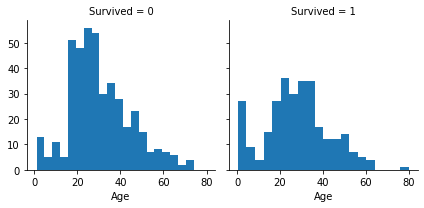

In [40]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### ここから分かること
- 乳児（4歳未満）の生存率が高い
- 最高齢者（80歳）は生存率が高い
- 多くの15-25歳の乗客は生存していない
- 乗客の多くは15-35歳の年齢層である  

### 仮説に対しての結論として
- 生存率との相関が大きいのでデータ補完を行い、学習に使うカラムとする
- また年齢は数値ではなく、グループ単位での設定がよい

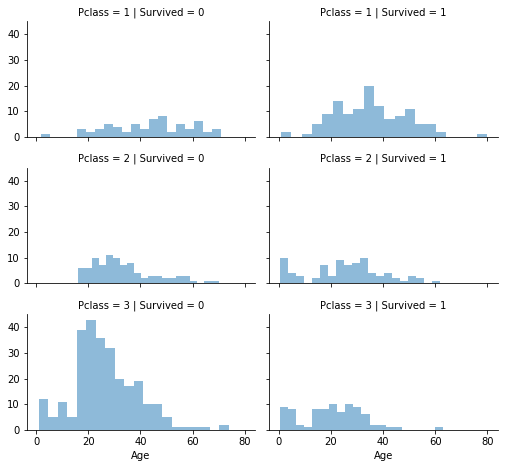

In [41]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

#### ここから分かること
- Pclass=3は最も多くの乗客を乗せていたが、ほとんどの乗客は生き残っていない
- Pclass=2とPclass=3の幼児乗客はほとんどが生存している
- Pclass=1の乗客のほとんどが生存している
- Pclassは乗客の年齢分布によって生存率が異なる

#### 仮説に対しての結論として
- Pclassも生存率との相関が大きいので、学習に使うカラムとする

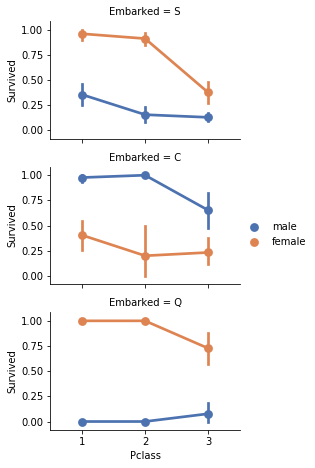

In [42]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

#### ここから分かること
- 女性乗客の方が男性よりも生存率が高い（既知）
- Embarked=Cは例外で、男性の方が生存率が高い。これは、PclassとEmbarked、そしてPclassとSurvivedの相関関係である可能性がありますが、必ずしもEmbarkedとSurvivedの間に直接的な相関関係があるわけではない
- Qポートでは、Pclass=2と比較してPclass=3の方が男性の生存率が高い
- 乗船した港は、Pclass=3と男性乗客の間で生存率に差がある

#### 仮説に対しての結論として
- 性別も生存率との相関が大きいので、学習に使うカラムとする
- Embarkedも補完して、学習に使うカラムとする

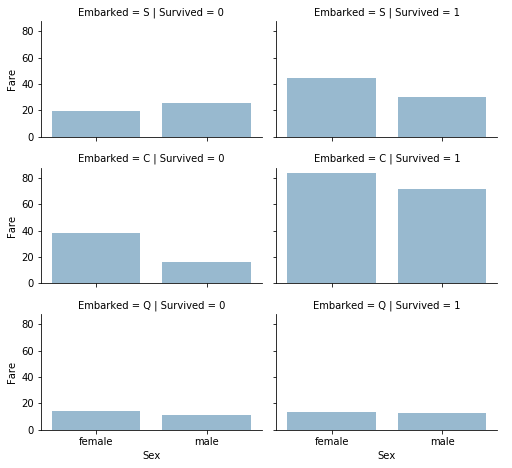

In [43]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

#### ここから分かること
- 高い運賃を支払う乗客の方が生存率が高い
- 乗船港は生存率と相関がある

#### 仮説に対しての結論として
- Fareの導入も考える

### 　■ データの加工
- 先までの仮説と結論を通して、データの加工を行っていきます！

In [44]:
# とりあえず生存率と相関を持っていない column である "Ticket" や　"Cabin"をデータとして削除します
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_dp_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_dp_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine_dp = [train_dp_df, test_dp_df]

"After", train_dp_df.shape, test_dp_df.shape, combine_dp[0].shape, combine_dp[1].shape
train_dp_df.head()

Before (891, 12) (418, 11) (891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


#### なぜデータをDropするのか
- 処理として扱いやすくなる（関数やライブラリをそのまま当てはめやすい状態になるため）
- データ情報が単純に減るので、速度的にも早くなる可能性がある

In [45]:
for dataset in combine_dp:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_dp_df['Title'], train_dp_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [46]:
# titleが追加されている
train_dp_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


#### この作業の意図は？
- Nameには生存率との相関は見られない（○○という名前だと助かるなんてありえないから）
- しかしNameに含まれる敬称としては相関を取る可能性がある
- したがって、その情報のみをtitleと設定して残すことにする

In [47]:
# 件数が少ない敬称は Rare に
for dataset in combine_dp:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_dp_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [48]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine_dp:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### この作業の意図は？
- 文字でのマッピング（今回でいうところのMrとかMiss）と数値でのマッピングでは後々楽になるのは数値
- 例えば学習時に文字でのマッピングされたデータを渡すとエラーが起こる可能性が高い
- また、単純に情報量が減るということも挙げられる

In [49]:
# PassengerIDとName（必要な情報は分別できたので）削除する
train_dp_df = train_dp_df.drop(['Name', 'PassengerId'], axis=1)
test_dp_df = test_dp_df.drop(['Name'], axis=1)
combine_dp = [train_dp_df, test_dp_df]
train_dp_df.shape, test_dp_df.shape

((891, 9), (418, 9))

In [50]:
# Sexも同じように 0 or 1 の数値型にマッピングする
for dataset in combine_dp:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_dp_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


## =======================　ここまでで一旦区切り =======================

### ■ 欠損値の補完作業
- 欠損値とは、具体的にはデータが含まれていないセルのこと
- 欠損値は空やNULLなどの状態で示される
- 欠損値となるセルは情報を持っていないため、学習のエラーを誘発したり学習の結果が汚れる恐れがある
- そのため、削除するまたは補完（データを補う）ことが必要となる
- 削除となると、対象のセルを含む**行単位**での削除となるため、その他データが多く含まれる場合は補完を選択する必要がある

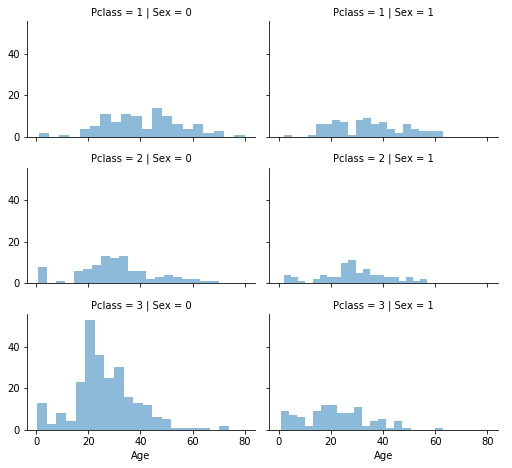

In [52]:
# 
grid = sns.FacetGrid(train_dp_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [53]:
# 配列の初期化（後で使うので）
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [55]:
# Ageの補完作業（補足は後述）
for dataset in combine_dp:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_dp_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


### この作業の意図は?
- 欠損値の補完を行うための作業（Ageのcolumnは欠損値が多く含まれている）
- 欠損値を補完する方法はいくつかあるが、今回はAgeの中央値を採用する（中央値を知らない人は調べてみてね）
- Age全体の中央値では、補完範囲が広くなりすぎるため、想定データとして誤差が大きくなりすぎる
- そのため、Pclass(全部で3クラス) x sex(全部で2クラス) = 6クラスでそれぞれ中央値を算出し、それを適合しているのが上記

In [61]:
# 年齢をレンジに分けて分割する
train_dp_df['AgeBand'] = pd.cut(train_dp_df['Age'], 5)
train_dp_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### この作業の意図は？
- cut関数でggってほしい
- シンプルに言うと、ビニング処理（ビン分割）を実施している
- 年齢のデータを5個（引数で設定）のクラスに自動で分割しているくれている処理
- (16.0, 32.0]という結果が出ていると思うが、実際は16 <= Age <= 32 に当てはまるクラスを表しているものとなる
- それらのAgeクラス（5クラス）と生存率の相関を示す作業となっている

In [68]:
for dataset in combine_dp:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_dp_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"
